# Data processing and manipulation

Our goal in this session is to:


1.   Process data acquired from previous session
2.   manipulate the data through various analytical methods



First, import the necessary packages

In [1]:
!pip install purpleair

import pandas as pd
from purpleair.sensor import Sensor
from purpleair.network import SensorList
from scipy import stats
import numpy as np

     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 127 kB 8.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Let's reacquire the code for my favourite Purpleair station in Nigeria

In [3]:
se = Sensor(57207)
df = se.parent.get_historical(52,thingspeak_field='primary')
df

,created_at,PM1.0 (CF=1) ug/m3,PM2.5 (CF=1) ug/m3,PM10.0 (CF=1) ug/m3,UptimeMinutes,ADC,Temperature_F,Humidity_%,PM2.5 (CF=ATM) ug/m3
entry_id,,,,,,,,,
297415,2022-02-13 00:00:16+00:00,70.94,95.19,115.62,28282.0,-68.0,84.0,55.0,62.74
297416,2022-02-13 00:02:13+00:00,68.93,95.93,116.14,28284.0,-64.0,84.0,55.0,63.26
297417,2022-02-13 00:04:13+00:00,70.16,95.07,116.88,28286.0,-68.0,84.0,55.0,62.73
297418,2022-02-13 00:06:13+00:00,70.14,95.88,113.88,28288.0,-69.0,84.0,55.0,63.00
297419,2022-02-13 00:08:13+00:00,69.24,94.57,115.67,28290.0,-69.0,84.0,55.0,62.35
...,...,...,...,...,...,...,...,...,...
71110,2021-02-20 23:50:54+00:00,108.79,171.10,221.83,16354.0,-66.0,77.0,41.0,113.25
71111,2021-02-20 23:52:54+00:00,110.39,174.27,228.09,16356.0,-65.0,77.0,42.0,115.54
71112,2021-02-20 23:54:54+00:00,109.49,167.75,219.07,16358.0,-66.0,77.0,42.0,111.11


This is a 2 min sampled data.  Can we resample it to hourly, 6-hourly, 12-hourly, or even daily mean?

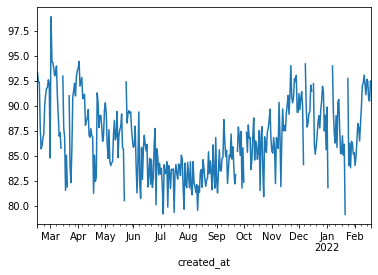

In [36]:
# So that pandas can easily identify the date values, we make it the index values.
df["created_at"] = pd.DatetimeIndex(df["created_at"])
dx = df.set_index('created_at')   #ds = df.resample(on='created_at',rule='H').mean()
dx_mean = dx.resample('D').mean()  # H, D, M, 
dx_sum = dx.resample('D').sum()

dx_mean['Temperature_F'].plot()


Sometimes, we will need the moving average to get a clean picture of what is happening

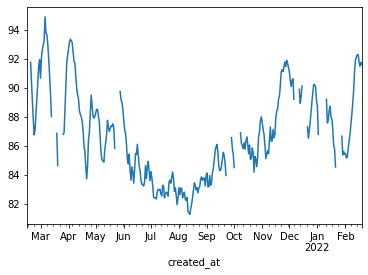

In [32]:
d_ma = dx_mean.rolling(window=5).mean()
d_ma['Temperature_F'].plot()

Is there any relationship between the variables in Purple air data?  Let's investigate.

In [43]:
#we look at PM2.5 and temperature
dx_mean = dx_mean.dropna(how='all')
slope, intercept, r, p, se = stats.linregress(dx_mean['Temperature_F'],dx_mean['PM2.5 (CF=1) ug/m3'])

slope, intercept, r, p, se



(19.074759460016427,
 -1530.7239384636814,
 0.11702734848407213,
 0.027034841074225414,
 8.591382553118098)

How does the correlation change over 7-day, 14-day, 30-day period?

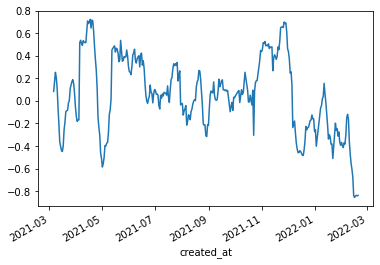

In [46]:
dx_roll_corr = dx_mean['Temperature_F'].rolling(21).corr(dx_mean['PM2.5 (CF=1) ug/m3'])

dx_roll_corr.plot()